In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt

# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

#### model fitting

In [4]:
from src.Bayesian_recon import *
from src.Bayesian_recon.problems.config import config_fgt
from src.Bayesian_recon.problems import *
from src.Bayesian_recon.utils.optimizer import Optimizer

In [5]:
def post_acc_amount_f(x):
    if x <= 0.2:
        return 0
    elif 0.2 < x < 0.3:
        return 1
    elif 0.3 <= x < 0.4:
        return 2
    elif 0.4 <= x < 0.5:
        return 3
    elif 0.5 <= x < 0.6:
        return 4
    elif 0.6 <= x < 0.7:
        return 5
    elif 0.7 <= x < 0.8:
        return 6
    elif 0.8 <= x <= 1:
        return 7

def random_acc_amount_f(x):
    return 7 - post_acc_amount_f(x)


module_config = {
    "cluster": (PartitionCluster, {
        "transition_spec":
        [("random_2", "top_posterior"),
         ("opp_random_2", "random")]})
    ,
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    })
}
optimizer = Optimizer(module_config, n_jobs=120)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

Error initializing module cluster: 'Optimizer' object has no attribute 'partition_model'


In [ ]:
iSub = 22
results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 8, 5, 1000)
    # list(range(1, 25))

In [ ]:
sub_results = results[iSub]
best_step_results = sub_results['best_step_results']
best_step_amounts = [step['best_step_amount'] for step in best_step_results if 'best_step_amount' in step]

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
os.makedirs(result_path, exist_ok=True)

joblib.dump(results, result_path / 'M_fgt_cl.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cl.joblib']

In [15]:
from src.Bayesian_recon.utils.model_evaluation import ModelEval
model_eval = ModelEval()

oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

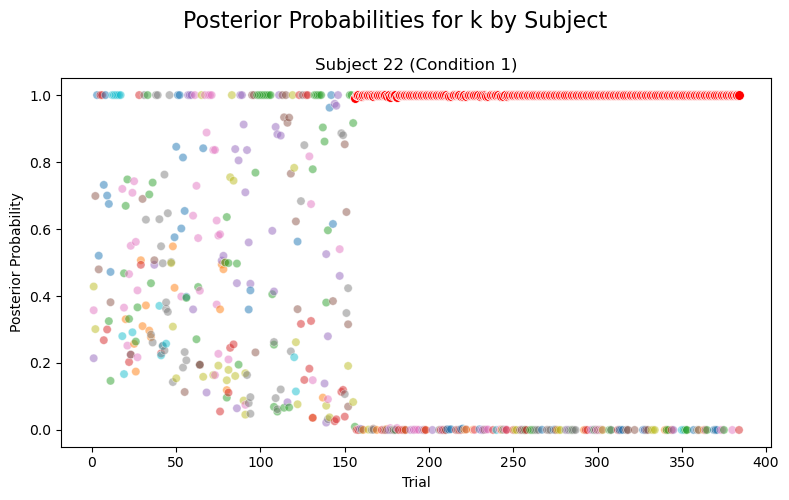

In [ ]:
model_eval.plot_posterior_probabilities(results, [iSub])

In [ ]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

Predicting tasks: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00, 886.75it/s]


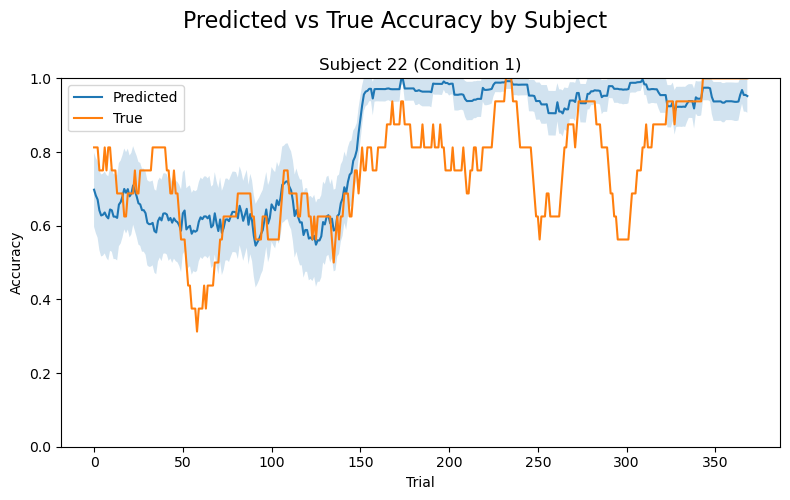

In [ ]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

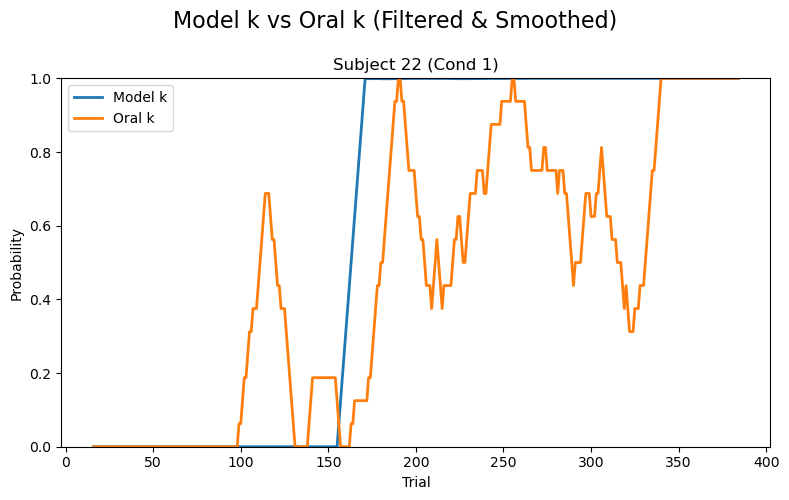

In [ ]:
model_eval.plot_k_oral_comparison(
    results, oral_hypo_hits, [iSub])

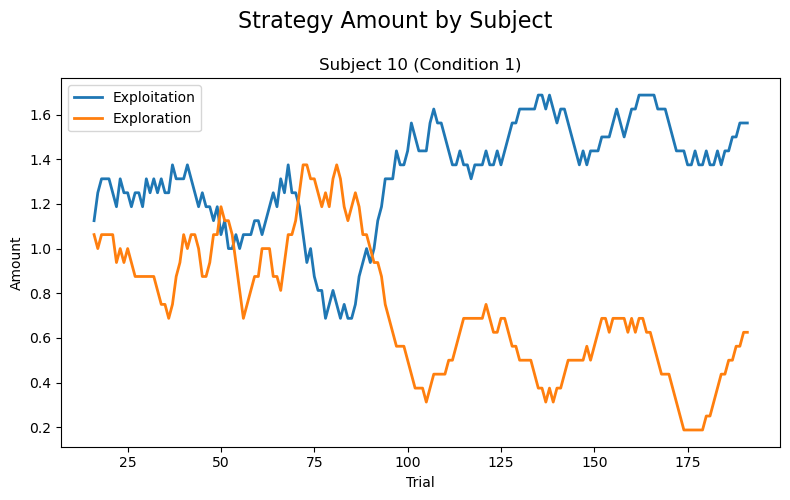

In [ ]:
model_eval.plot_cluster_amount(results, 16, [iSub])

#### plot

In [1]:
model_name = "M_fgt_cl_per"

In [6]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
results = joblib.load(result_path / f'{model_name}.joblib')

In [7]:
from src.Bayesian_recon.utils.model_evaluation import ModelEval
model_eval = ModelEval()

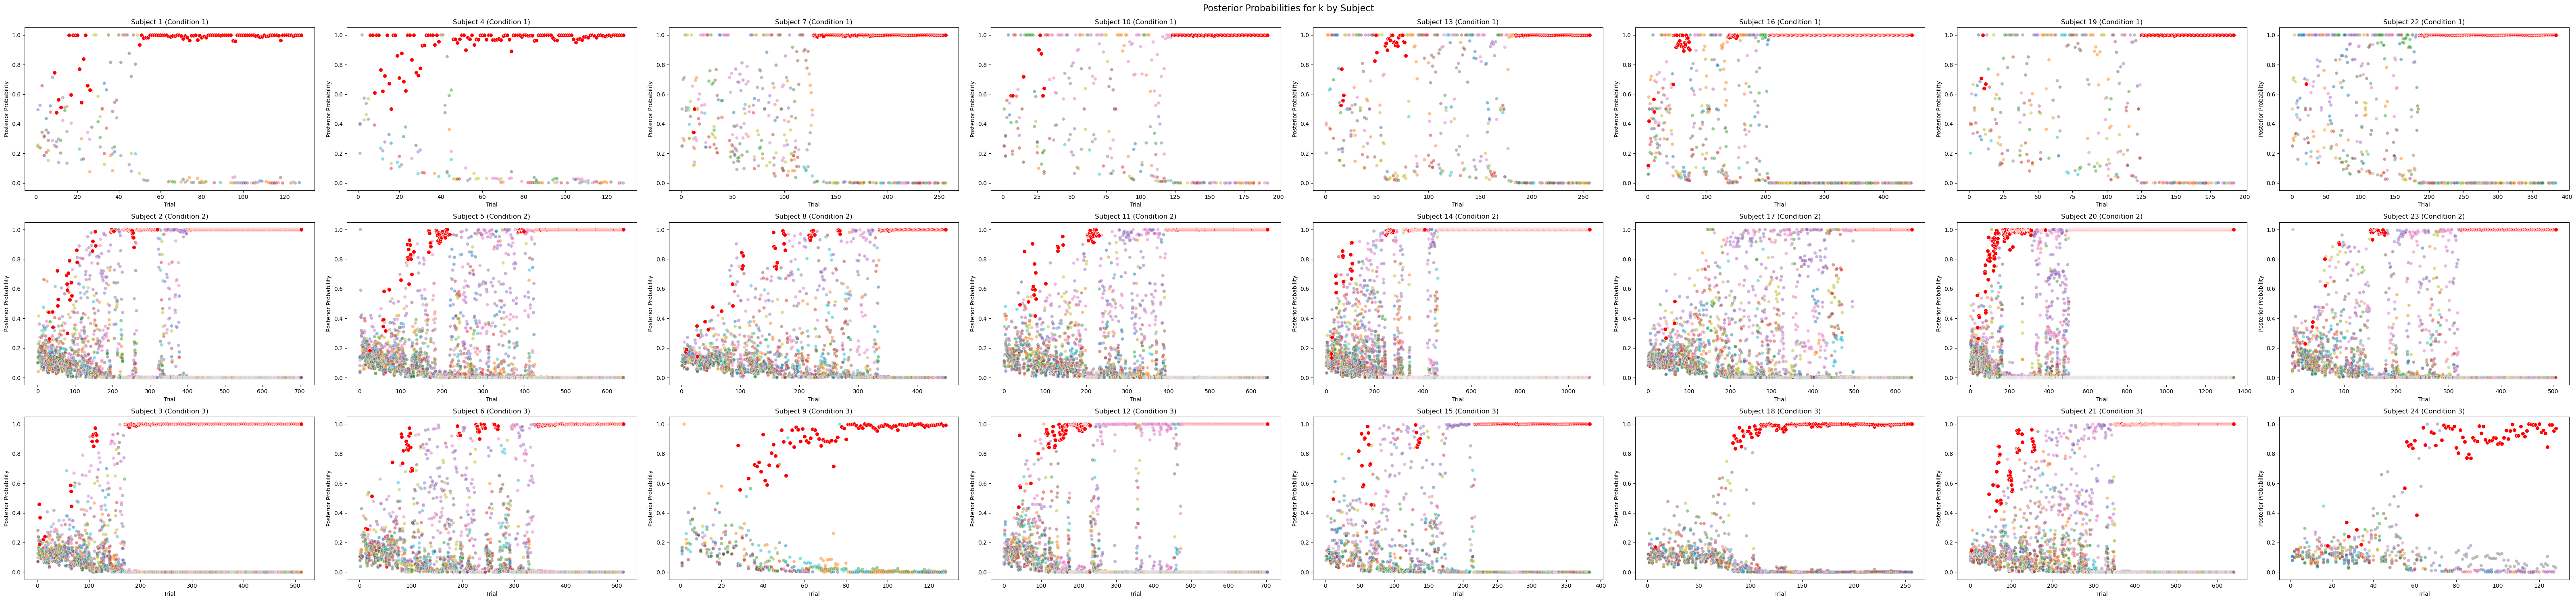

In [8]:
model_eval.plot_posterior_probabilities(
    results, save_path=result_path/f'{model_name}_post.png')

In [9]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, range(1,25))

Predicting tasks: 100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 1116.60it/s]


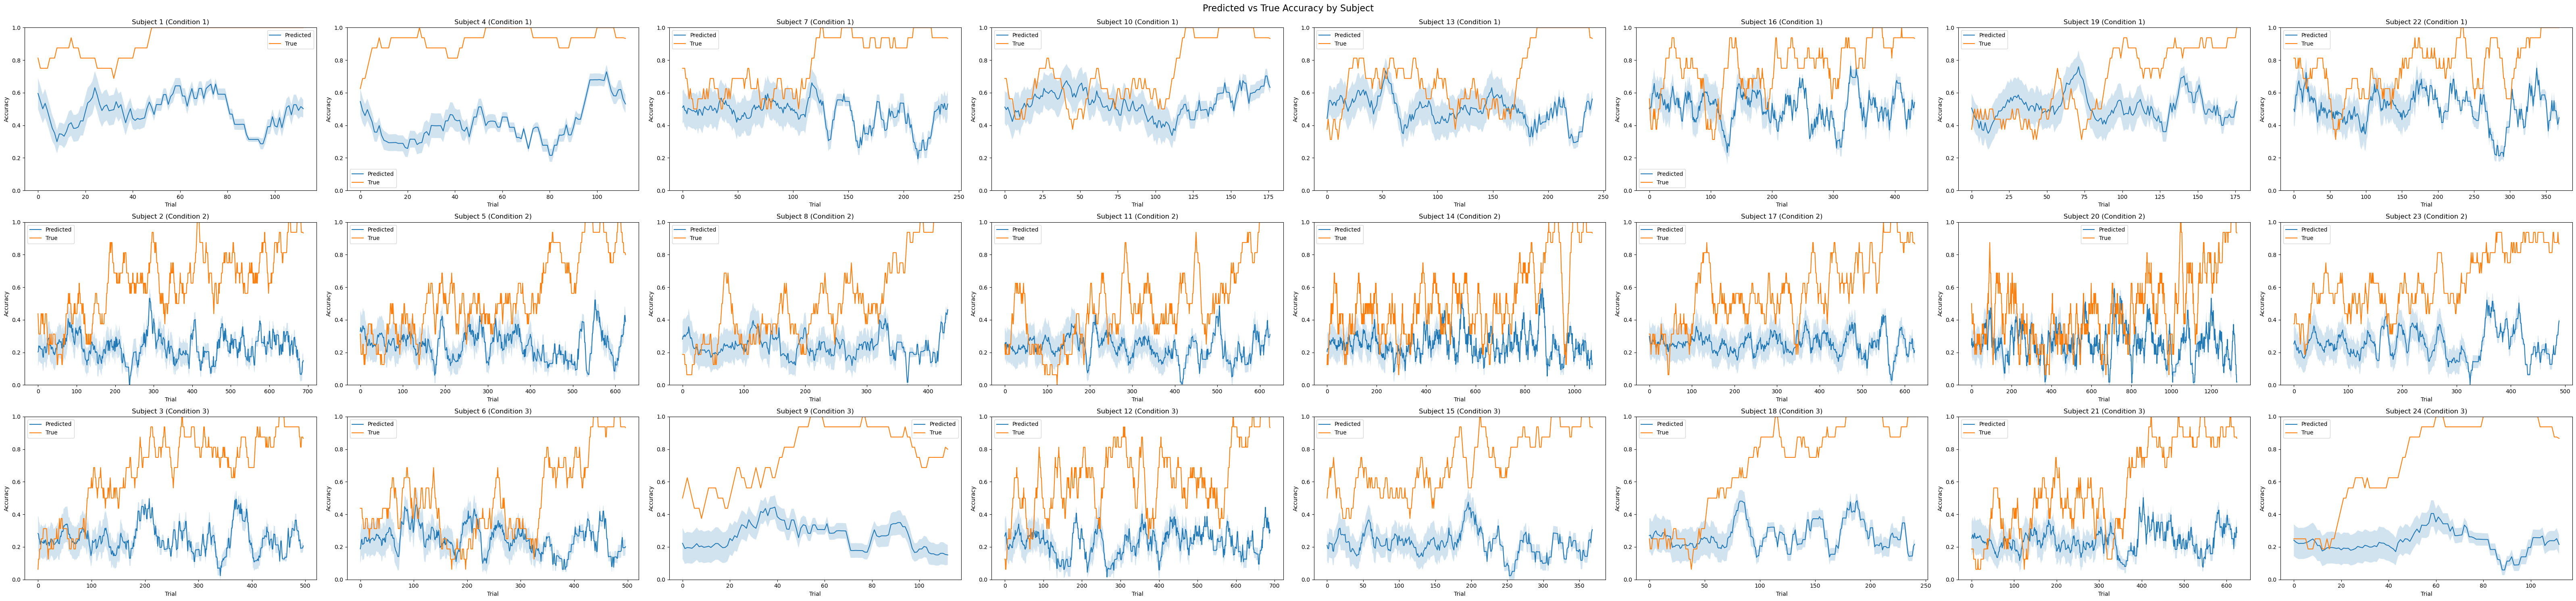

In [10]:
model_eval.plot_accuracy_comparison(prediction, save_path=result_path/f'{model_name}_acc.png')

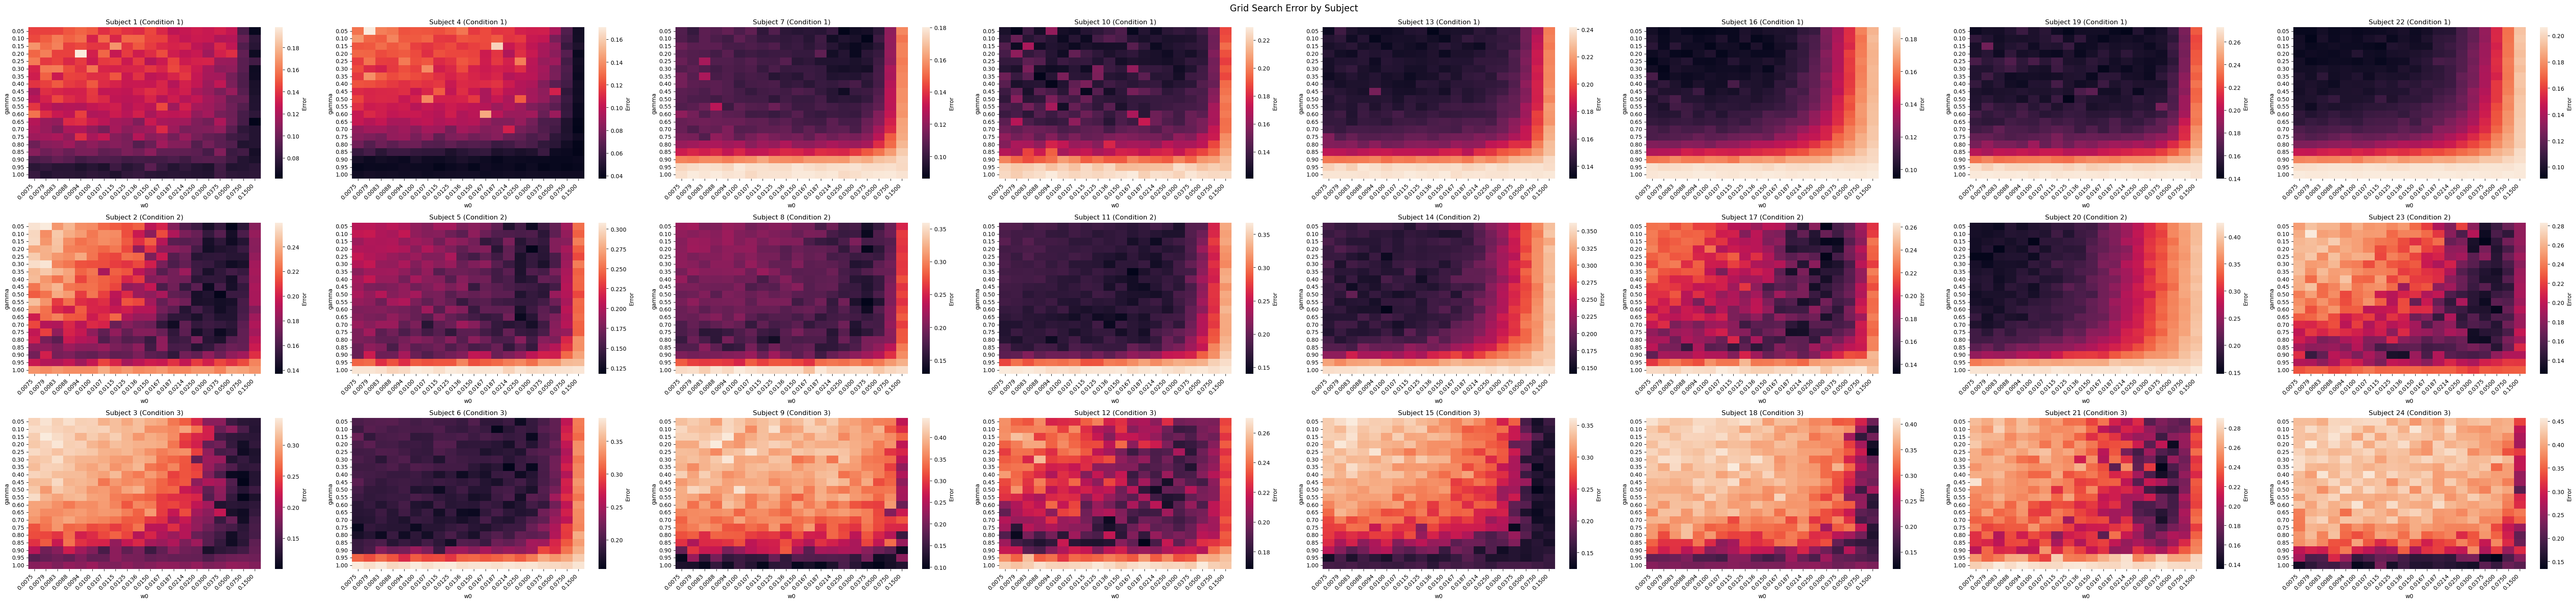

In [ ]:
model_eval.plot_error_grids(results, fname=['gamma','w0'], save_path=result_path/f'{model_name}_grid.png')

In [ ]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

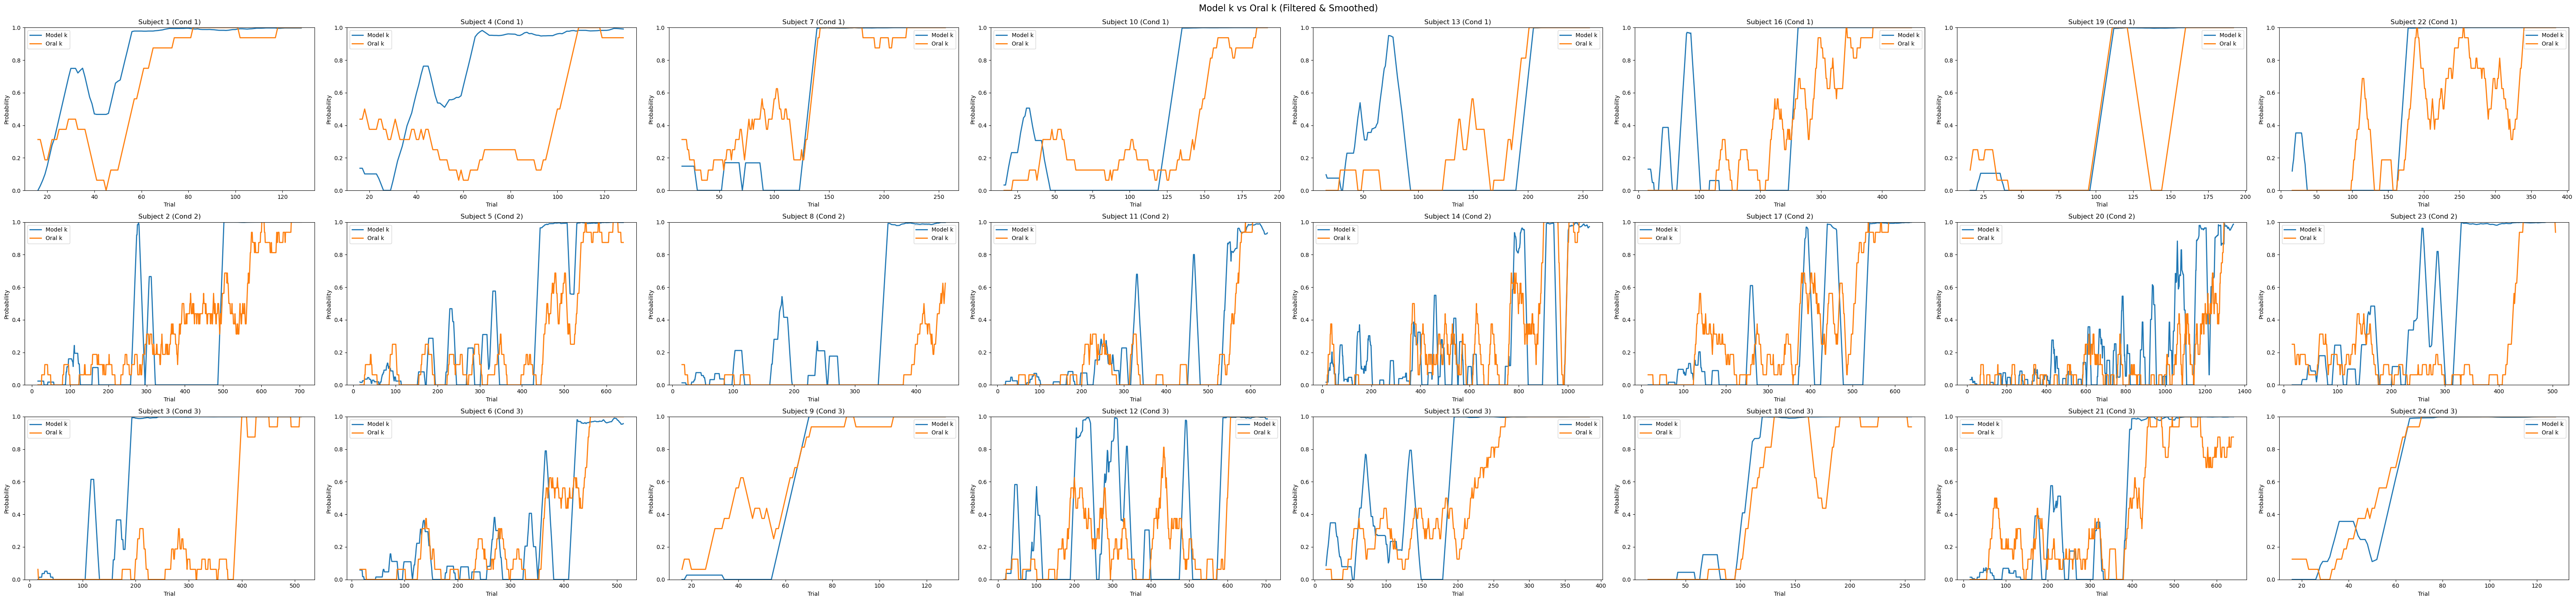

In [48]:
model_eval.plot_k_oral_comparison(
    results, oral_hypo_hits,
    range(1,25), save_path=result_path/f'{model_name}_oral.png')

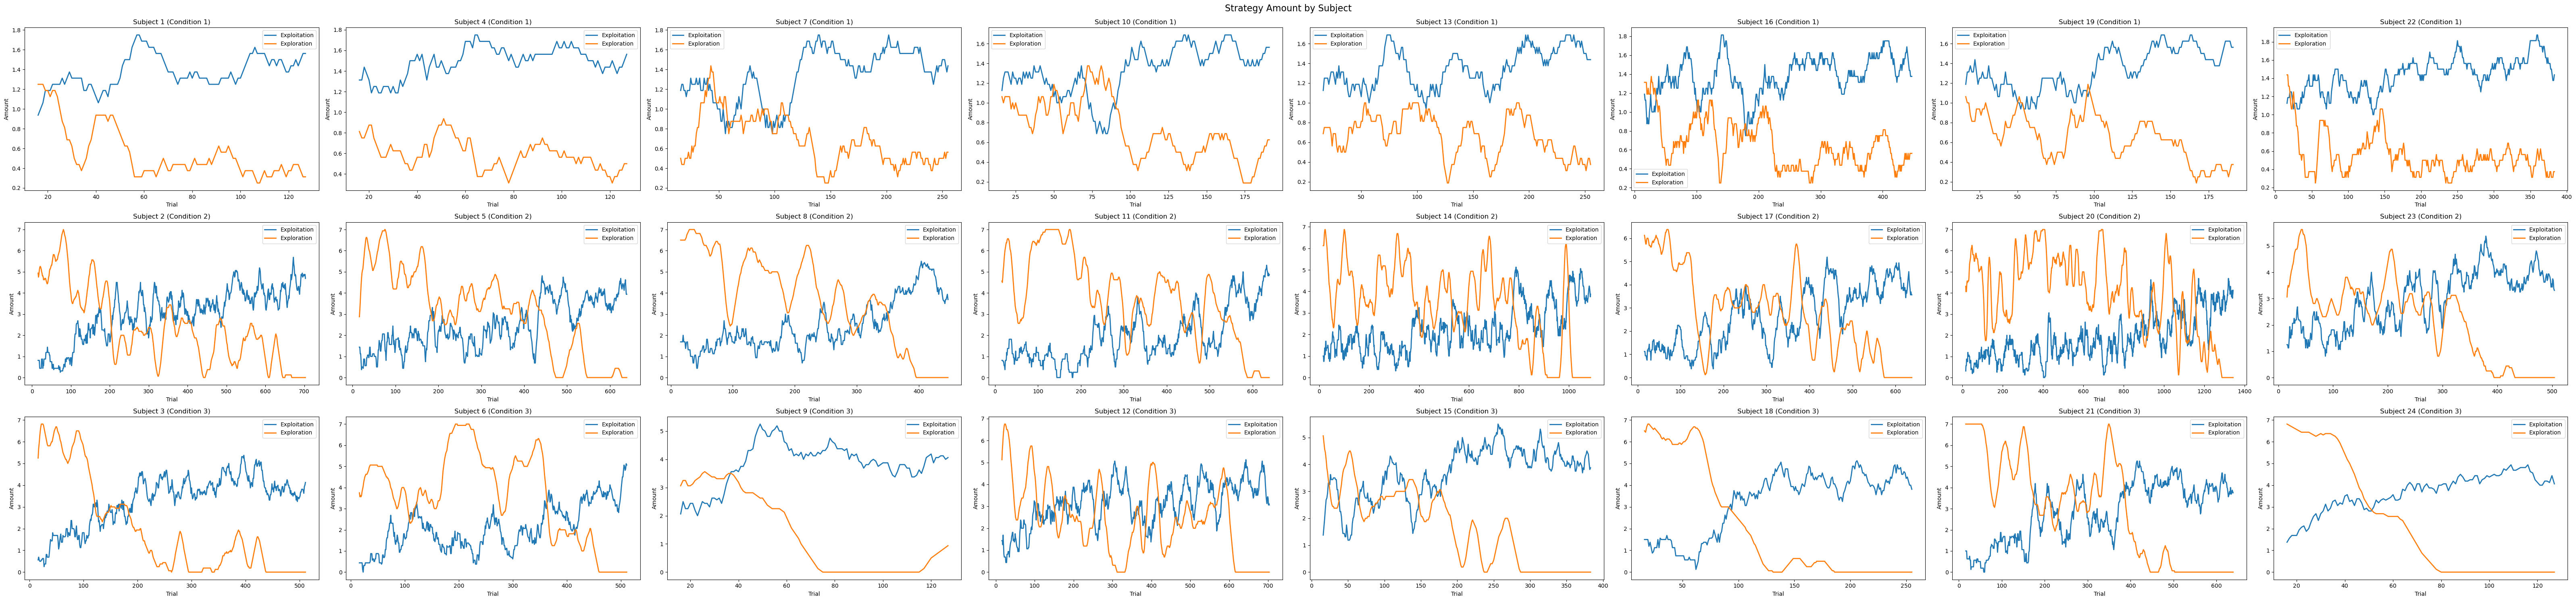

In [46]:
model_eval.plot_cluster_amount(results, window_size=16, save_path=result_path/f'{model_name}_amount.png')

In [40]:
# 用法示例（画完图后直接调用）：
metrics_df = model_eval.compute_crossing_metrics(results, window_size=16)

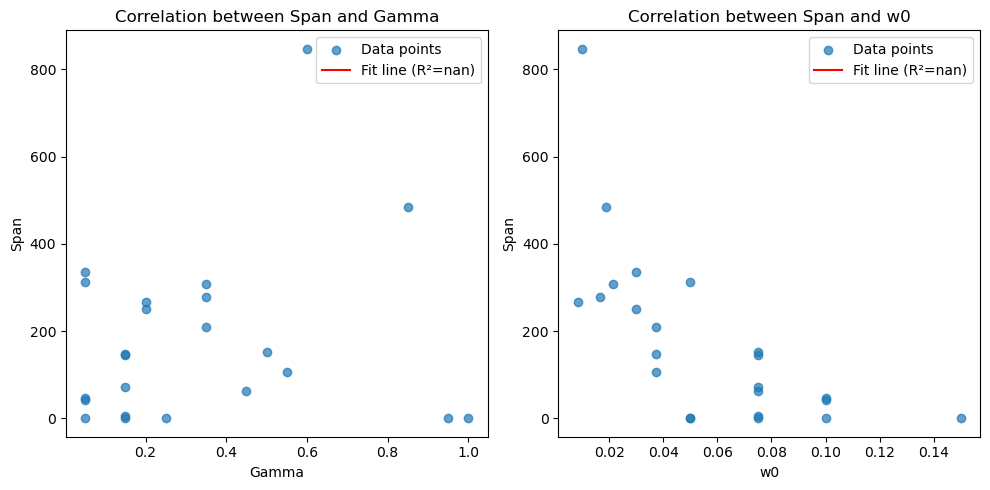

In [47]:
from scipy.stats import linregress

# 提取 metrics_df 中的 Span 列
spans = metrics_df['Span']
firstcross = metrics_df['FirstCross']

# 提取 cluster_results 中的 gamma 和 w0
gammas = [results[i]['best_params']['gamma'] for i in metrics_df.index]
w0s = [results[i]['best_params']['w0'] for i in metrics_df.index]

# 计算 Span 和 gamma 的相关性并绘制散点图和回归直线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gammas, spans, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(gammas, spans)
plt.plot(gammas, [slope * x + intercept for x in gammas], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('Gamma')
plt.ylabel('Span')
plt.title('Correlation between Span and Gamma')
plt.legend()

# 计算 Span 和 w0 的相关性并绘制散点图和回归直线
plt.subplot(1, 2, 2)
plt.scatter(w0s, spans, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(w0s, spans)
plt.plot(w0s, [slope * x + intercept for x in w0s], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('w0')
plt.ylabel('Span')
plt.title('Correlation between Span and w0')
plt.legend()

plt.tight_layout()
plt.show()

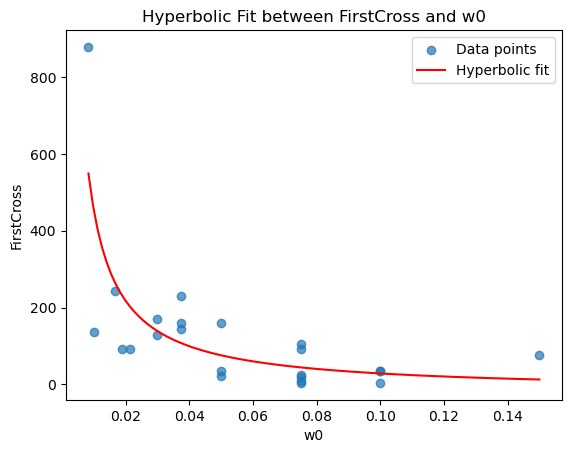

Hyperbolic fit parameters: a = 4.728450453485582, b = -18.638123284355952


In [44]:
from scipy.optimize import curve_fit
import numpy as np

# 定义双曲线函数
def hyperbola(x, a, b):
    return a / x + b

# 去掉 w0=0.15 的极端值并过滤掉 NaN 值
filtered_data = [(w0, fc) for w0, fc in zip(w0s, firstcross) if w0 != 0.16 and not np.isnan(fc)]
filtered_w0s, filtered_spans = zip(*filtered_data)

# 拟合双曲线
params, _ = curve_fit(hyperbola, filtered_w0s, filtered_spans, maxfev=10000)
a, b = params

# 绘制拟合曲线
w0_range = np.linspace(min(filtered_w0s), max(filtered_w0s), 100)
fitted_spans = hyperbola(w0_range, a, b)

plt.scatter(filtered_w0s, filtered_spans, alpha=0.7, label='Data points')
plt.plot(w0_range, fitted_spans, color='red', label='Hyperbolic fit')
plt.xlabel('w0')
plt.ylabel('FirstCross')
plt.title('Hyperbolic Fit between FirstCross and w0')
plt.legend()
plt.show()

# 输出拟合的双曲线参数
print(f"Hyperbolic fit parameters: a = {a}, b = {b}")

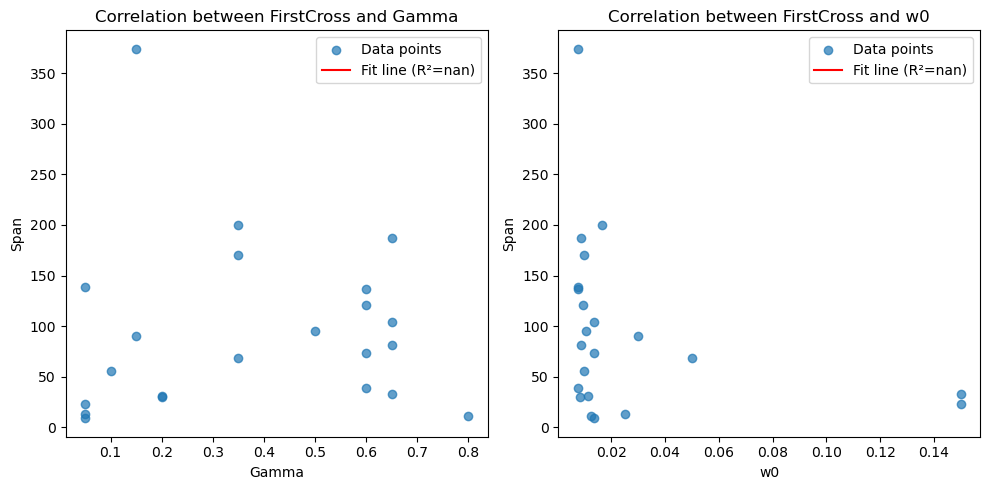

In [ ]:
from scipy.stats import linregress

# 提取 metrics_df 中的 FirstCross 列
firstcross = metrics_df['FirstCross']

# 提取 cluster_results 中的 gamma 和 w0
gammas = [cluster_results[i]['best_params']['gamma'] for i in metrics_df.index]
w0s = [cluster_results[i]['best_params']['w0'] for i in metrics_df.index]

# 计算 Span 和 gamma 的相关性并绘制散点图和回归直线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gammas, firstcross, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(gammas, firstcross)
plt.plot(gammas, [slope * x + intercept for x in gammas], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('Gamma')
plt.ylabel('Span')
plt.title('Correlation between FirstCross and Gamma')
plt.legend()

# 计算 Span 和 w0 的相关性并绘制散点图和回归直线
plt.subplot(1, 2, 2)
plt.scatter(w0s, firstcross, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(w0s, firstcross)
plt.plot(w0s, [slope * x + intercept for x in w0s], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('w0')
plt.ylabel('Span')
plt.title('Correlation between FirstCross and w0')
plt.legend()

plt.tight_layout()
plt.show()

####  q

In [ ]:
from pathlib import Path
import joblib

# 获取所有带有指定前缀的文件
files_to_merge = list(result_path.glob("M_fgt_cl_*.joblib"))

# 合并文件内容
merged_data = {}
for file in files_to_merge:
    data = joblib.load(file)
    merged_data.update(data)

# 保存合并后的文件
output_file = result_path / "M_fgt_cl.joblib"
joblib.dump(merged_data, output_file)

print(f"Merged file saved to {output_file}")